In [2]:
import pandas as pd
from sqlalchemy import create_engine, text
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib
import numpy as np
import os

print("Librerías importadas exitosamente.")

Librerías importadas exitosamente.


In [4]:
load_dotenv('../.env')

DATABASE_URL = os.getenv("DATABASE_URL")

if not DATABASE_URL:
    raise ValueError("¡No se encontró la DATABASE_URL! Asegúrate de que tu archivo ../.env esté correcto.")

try:
    engine = create_engine(DATABASE_URL)
    print("Conexión a la base de datos PostgreSQL establecida.")
except Exception as e:
    print(f"Error al conectar a la base de datos: {e}")

Conexión a la base de datos PostgreSQL establecida.


In [6]:
sql_query = text("""
    SELECT 
        DATE(creado_en) as fecha, 
        SUM(total_pedido) as total_ventas
    FROM 
        pedidos_pedido
    WHERE 
        estado IN ('PAGADO', 'ENVIADO', 'ENTREGADO')
    GROUP BY 
        DATE(creado_en)
    ORDER BY 
        fecha;
""")

df_ventas = pd.read_sql(sql_query, engine, index_col='fecha', parse_dates=True)
df_ventas = df_ventas.asfreq('D', fill_value=0)
print(f"Datos cargados. Total de días: {len(df_ventas)}")
print("\nÚltimos 5 días de datos:")
df_ventas.tail()

Datos cargados. Total de días: 731

Últimos 5 días de datos:


,total_ventas
fecha,
2025-11-08,2139.04
2025-11-09,3521.67
2025-11-10,68017.41
2025-11-11,758340.39
2025-11-12,3381.48


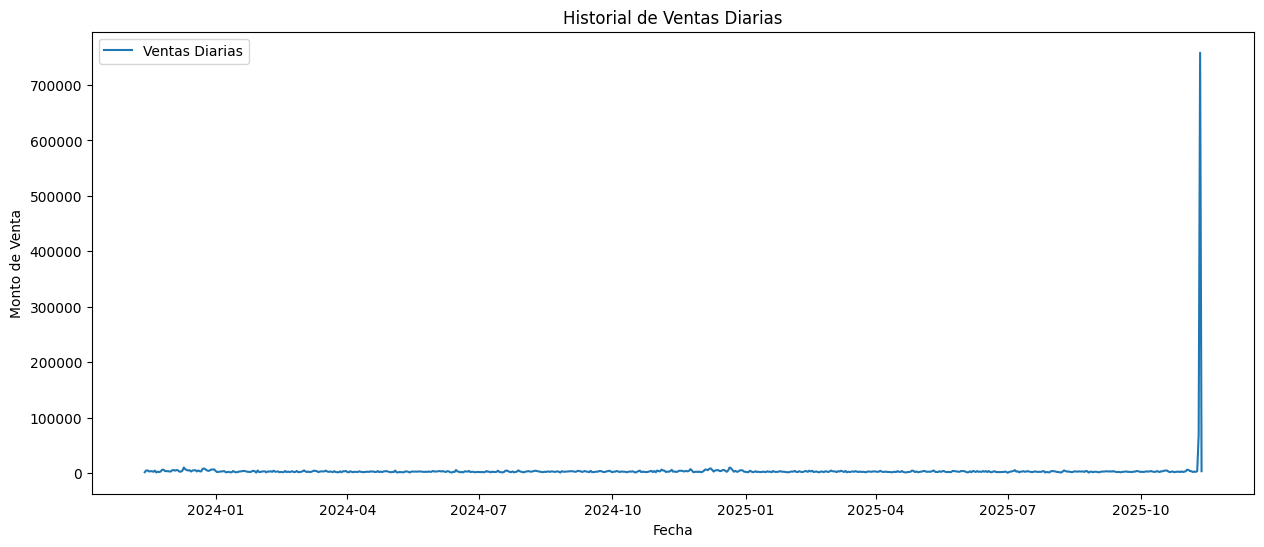

In [7]:
plt.figure(figsize=(15, 6))
plt.plot(df_ventas['total_ventas'], label='Ventas Diarias')
plt.title('Historial de Ventas Diarias')
plt.xlabel('Fecha')
plt.ylabel('Monto de Venta')
plt.legend()
plt.show()

In [8]:
def crear_features(df):
    """Crea características de series de tiempo a partir de un índice de fecha."""
    df_copy = df.copy()
    df_copy['dia_del_mes'] = df_copy.index.day
    df_copy['dia_de_la_semana'] = df_copy.index.dayofweek  # Lunes=0, Domingo=6
    df_copy['mes'] = df_copy.index.month
    df_copy['anio'] = df_copy.index.year
    df_copy['trimestre'] = df_copy.index.quarter
    
    # Característica "Lag" (Ventas del día anterior)
    # .shift(1) mueve los datos un día hacia abajo
    df_copy['ventas_dia_anterior'] = df_copy['total_ventas'].shift(1)
    
    # Característica "Rolling" (Promedio de la última semana)
    df_copy['media_ventas_7_dias'] = df_copy['total_ventas'].shift(1).rolling(window=7).mean()
    
    # Llenamos los valores 'NaN' (primeros 7 días) con 0
    df_copy = df_copy.fillna(0)
    
    return df_copy

df_features = crear_features(df_ventas)

print("Datos con nuevas características (features):")
df_features.tail()

Datos con nuevas características (features):


,total_ventas,dia_del_mes,dia_de_la_semana,mes,anio,trimestre,ventas_dia_anterior,media_ventas_7_dias
fecha,,,,,,,,
2025-11-08,2139.04,8,5,11,2025,4,2694.18,3794.104286
2025-11-09,3521.67,9,6,11,2025,4,2139.04,3646.968571
2025-11-10,68017.41,10,0,11,2025,4,3521.67,3289.732857
2025-11-11,758340.39,11,1,11,2025,4,68017.41,12185.634286
2025-11-12,3381.48,12,2,11,2025,4,758340.39,120003.948571


In [10]:
# 1. Definir qué queremos predecir (y) y qué usaremos para predecir (X)
TARGET = 'total_ventas'
# Usamos todas las columnas MENOS la que queremos predecir
FEATURES = [col for col in df_features.columns if col != TARGET]

X = df_features[FEATURES]
y = df_features[TARGET]

# 2. Separar los datos
# 80% para entrenar, 20% para probar que funciona
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
# 'shuffle=False' es CLAVE en series de tiempo. No podemos "revolver" el tiempo.

print(f"Total de días: {len(X)}")
print(f"Días para entrenar: {len(X_train)}")
print(f"Días para probar: {len(X_test)}")

# 3. Crear y Entrenar el modelo
# n_estimators=100 significa que usará 100 "árboles"
modelo = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

print("\nEntrenando el modelo...")
modelo.fit(X_train, y_train)
print("¡Modelo entrenado!")

# 4. Probar qué tan bueno es
score = modelo.score(X_test, y_test)
print(f"\nPuntuación del modelo (R-squared): {score:.2f}")
# (Una puntuación de 1.0 es perfecta, 0.0 es terrible. > 0.6 es bueno)

Total de días: 731
Días para entrenar: 584
Días para probar: 147

Entrenando el modelo...
¡Modelo entrenado!

Puntuación del modelo (R-squared): -0.00


In [11]:
# Guardamos el modelo en la carpeta 'modelo/' que definimos en nuestra estructura
# (Recuerda que estamos en 'notebooks/', así que usamos '../modelo/')
ruta_guardado = '../modelo/modelo_random_forest.pkl'

joblib.dump(modelo, ruta_guardado)

print(f"¡Modelo guardado exitosamente en: {ruta_guardado}")

¡Modelo guardado exitosamente en: ../modelo/modelo_random_forest.pkl
